In [ ]:
using ExpDataSets, Dates, CSV, FileIO, JLD2, Chain, DataFrames, DataFramesMeta, StatsBase, Measurements, Plots
include("other_utils.jl")


In [ ]:
et = load("Data/behavior_dataset.jld2", "event_time_series");

In [5]:
oi = @chain begin
    @subset(et, :agent .== "Object", :behavior .== "Immobility")
    select(:lfp, :file, :start_time, :end_time)
    @transform(@byrow :duration = duration(:lfp))
    minimum(_.duration)
end

2.7997227997227583

In [ ]:
ps = @chain et begin
    @subset((:end_time .- :start_time) .≥ 1.0)
    transform(:lfp => ByRow.(x -> normalize(x)) => :lfp)
    transform(:lfp => ByRow.(x -> binps(compute_power_spectrum(x), 60, 120)) => :pspec)
    @select(:rat, :trial_type, :agent, :behavior, :region, :pspec)
end

In [ ]:
null_region_mps = @chain ps begin
    @subset(:behavior .== "null")
    transform(:pspec => ByRow.(x -> values(x)) => :pspec)
    groupby([:region])
    @combine(:mps = [meanandstderr(:pspec)])
    transform(:mps => ByRow.(x -> Measurements.value.(x)) => :mpsvals, :mps => ByRow.(x -> Measurements.uncertainty.(x)) => :err)
    select(:region, :mpsvals => :mps, :err)
end

In [ ]:
behavior_mps = @chain ps begin
    @subset(:behavior .!= "null")
    transform(:pspec => ByRow.(x -> values(x)) => :pspec)
    groupby([:behavior, :region])
    @combine(:mps = [meanandstderr(:pspec)])
    transform(:mps => ByRow.(x -> Measurements.value.(x)) => :mpsvals, :mps => ByRow.(x -> Measurements.uncertainty.(x)) => :err)
    select(:behavior, :region, :mpsvals => :mps, :err)
end

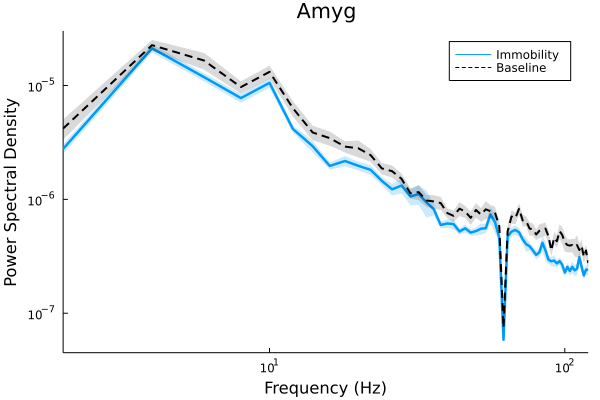

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423


In [11]:
freqs = 2:2:120;
b = "Immobility";
r = "Amyg";
s = @subset(behavior_mps, :behavior .== b, :region .== lowercase(r))
labels = r
specs = s.mps
errs = s.err

gr()
p = plot(
    freqs,
    specs,
    ribbon = errs[1],
    fillalpha = 0.2,
    label = b,
    xaxis = :log,
    yaxis = :log,
    ylabel = "Power Spectral Density",
    xlabel = "Frequency (Hz)",
    title = r,
    linewidth = 2.5,
    grid = false,
)
ns = @subset(null_region_mps, :region .== lowercase(r))
plot!(p, freqs, ns.mps, ribbon = ns.err[1], fillcolor = :black, fillalpha = 0.15, linewidth = 2, xlim = (2, 120), linestyle = :dash, linecolor = :black, label = "Baseline")



In [ ]:
# freqs=2:2:120;  b="Immobility";  r="Amyg" 
# s=@subset(behavior_mps, :behavior.== b, :region.==lowercase(r))

# # labels =reshape(s.agent,1,length(s.agent)) 
# labels = r
# specs = s.mps
# errs = s.err

# gr()
# p=plot(
#     freqs, 
#     specs, 
#     ribbon=errs, 
#     fillalpha=.2, 
#     # label=labels, 
#     xaxis=:log,
#     yaxis=:log, 
#     ylabel="Power Spectral Density", 
#     xlabel="Frequency (Hz)", 
#     title=b*"\n"*r,
#     linewidth=2.5,
#     grid=false,
    
# )
# # ns=@subset(null_region_mps, :region.== lowercase(r))
# # plot!(p, freqs, ns.mps, ribbon= ns.err, fillcolor=:black, fillalpha=.15, linewidth=2,  xlim=(2,120), linestyle=:dash, linecolor=:black, label="Baseline", legendtitle="Agent")




In [ ]:
# imm_mob=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "MOB")
# plot!(imm_mob, title="MOB", xlabel="", ylabel="Immobility\n\nPower Spectral Density")
# imm_amyg=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "Amyg")
# plot!(imm_amyg, title="Amygdala", xlabel="")
# imm_ca=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "CA2")
# plot!(imm_ca, title="Ca2", xlabel="", legendfontsize = 9, legend = :topright)
# rear_mob=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "MOB")
# plot!(rear_mob, title="", xlabel="Frequency Hz", ylabel="Rearing\n\nPower Spectral Density")
# rear_amyg=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "Amyg")
# plot!(rear_amyg, title="", xlabel="Frequency Hz")
# rear_ca=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "CA2")
# plot!(rear_ca, title="", xlabel="Frequency Hz", legendfontsize = 9, legend = :topright)

# p=plot(imm_mob, imm_amyg, imm_ca, rear_mob, rear_amyg, rear_ca)
# plot!(p, grid=false, size = (1100, 600))
# plot!(p, yticks=[10.0^x for x in -7:1:-4], ylim=(10.0^-7.5, 10.0^-3.5), xlim=(2,120))
# # plot!(p, linestyle=[:solid :solid :solid :dash], linewidth=[3 3 3 3])

# PyPlot.suptitle("Region")
# PyPlot.savefig("suptile_test.png")


In [ ]:
# plot!(imm_ca, title="Ca2", xlabel="", legendfontsize = 9, legend = :topright)
# rear_mob=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "MOB")
# plot!(rear_mob, title="", xlabel="Frequency Hz", ylabel="Rearing\n\nPower Spectral Density")
# rear_amyg=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "Amyg")
# plot!(rear_amyg, title="", xlabel="Frequency Hz")
# rear_ca=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "CA2")
# plot!(rear_ca, title="", xlabel="Frequency Hz", legendfontsize = 9, legend = :topright)

# p=plot(imm_mob, imm_amyg, imm_ca, rear_mob, rear_amyg, rear_ca)
# plot!(p, grid=false, size = (1100, 600))
# plot!(p, yticks=[10.0^x for x in -7:1:-4], ylim=(10.0^-7.5, 10.0^-3.5), xlim=(2,120))
# # plot!(p, linestyle=[:solid :solid :solid :dash], linewidth=[3 3 3 3])

# PyPlot.suptitle("Region")
# PyPlot.savefig("suptile_test.png")


In [ ]:

# p=plot(imm_mob, imm_amyg, imm_ca, rear_mob, rear_amyg, rear_ca)
# plot!(p, grid=false, size = (1100, 600))
# plot!(p, yticks=[10.0^x for x in -7:1:-4], ylim=(10.0^-7.5, 10.0^-3.5), xlim=(2,120))
# # plot!(p, linestyle=[:solid :solid :solid :dash], linewidth=[3 3 3 3])

# PyPlot.suptitle("Region")
# PyPlot.savefig("suptile_test.png")
